In [2]:
import apogee.tools.read as apread
import matplotlib.pyplot as plt
import apogee.tools.path as apogee_path
from apogee.tools import bitmask

import random
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn

from apoNN.src.datasets import ApogeeDataset

from tagging.src.networks import ConditioningAutoencoder,Embedding_Decoder,Feedforward,ParallelDecoder,Autoencoder

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apogee_path.change_dr(16)

In [3]:
allStar= apread.allStar(rmcommissioning=True,main=False,ak=True, akvers='targ',adddist=False)


/share/splinter/ddm/taggenv/lib64/python3.6/site-packages/apogee/tools/read.py:303: RuntimeWarning: Extinction-corrected J,H,K not added because esutil is not installed
  warnings.warn("Extinction-corrected J,H,K not added because esutil is not installed",RuntimeWarning)


In [4]:
upper_temp_cut = allStar["Teff"]<5000
lower_temp_cut = allStar["Teff"]>4000
lower_g_cut = allStar["logg"]>1.5
upper_g_cut = allStar["logg"]<3
snr_cut = allStar["SNR"]>100
snr_highcut = allStar["SNR"]<500
feh_outliercut = allStar["Fe_H"]>-5

combined_cut = lower_g_cut & upper_g_cut & lower_temp_cut & upper_temp_cut & snr_cut & snr_highcut & feh_outliercut

In [5]:
cut_allStar = allStar[combined_cut]

In [6]:
cut_allStar["telescope"]

chararray(['apo25m', 'apo25m', 'apo25m', ..., 'apo25m', 'apo25m',
           'apo25m'], dtype='<U8')

### Parameters



In [54]:
n_batch = 64
n_z = 20
n_bins = 2000
lr = 0.001
n_datapoints = 8000

### Training

In [55]:
dataset = ApogeeDataset(cut_allStar[:n_datapoints])
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = n_batch,
                                     shuffle= True,
                                     drop_last=True)

In [56]:
dataset[0]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor([0.3061, 0.3904]), 0)

In [98]:
encoder = Feedforward([n_bins,512,128,n_z],activation=nn.LeakyReLU()).to(device)
decoder = Feedforward([n_z,128,512,1024,2048,n_bins],activation=nn.LeakyReLU()).to(device)

autoencoder = Autoencoder(encoder,decoder,n_bins=n_bins).to(device)
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters(), lr=lr)

In [99]:
autoencoder = torch.load("/share/splinter/ddm/taggingProject/apogeeFactory/outputs/pretrained/ae1")


In [59]:
loss = nn.L1Loss()


(array([   53.,   263.,   539.,  1125.,  1290.,  6538., 33609., 39362.,
        21062.,  1699.]),
 array([-2.3548615 , -2.0558164 , -1.7567716 , -1.4577265 , -1.1586815 ,
        -0.85963655, -0.5605915 , -0.26154652,  0.03749847,  0.33654347,
         0.63558847], dtype=float32),
 <a list of 10 Patch objects>)

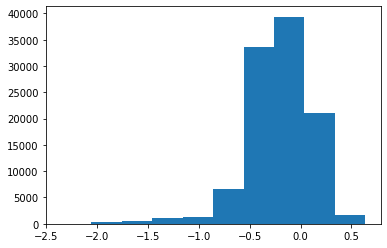

In [60]:
plt.hist(cut_allStar["Fe_H"])

In [61]:
for i in range(20000):
    for j,(x,u,idx) in enumerate(loader):

        optimizer_autoencoder.zero_grad()
        x_pred,z = autoencoder(x[:,1000:3000].to(device))

        err_pred = loss(x_pred,x[:,1000:3000].to(device))

        err_tot = err_pred
        err_tot.backward()
        optimizer_autoencoder.step()
        if j%100==0:
            print(f"err:{err_tot},err_pred:{err_pred}")


err:0.010389059782028198,err_pred:0.010389059782028198                          
err:0.010942532680928707,err_pred:0.010942532680928707                          
err:0.010352936573326588,err_pred:0.010352936573326588                          
err:0.011209053918719292,err_pred:0.011209053918719292
err:0.01115773431956768,err_pred:0.01115773431956768
err:0.011475290171802044,err_pred:0.011475290171802044
err:0.010513721965253353,err_pred:0.010513721965253353
err:0.012687773443758488,err_pred:0.012687773443758488
err:0.011878340505063534,err_pred:0.011878340505063534
err:0.012092518620193005,err_pred:0.012092518620193005
err:0.0117475725710392,err_pred:0.0117475725710392
err:0.012706127017736435,err_pred:0.012706127017736435
err:0.013116144575178623,err_pred:0.013116144575178623
err:0.011091921478509903,err_pred:0.011091921478509903
err:0.010621827095746994,err_pred:0.010621827095746994
err:0.012878908775746822,err_pred:0.012878908775746822
err:0.011041929945349693,err_pred:0.011041929945

KeyboardInterrupt: 

(0.0, 1.3)

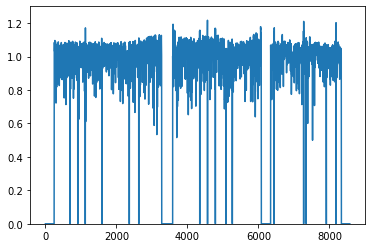

In [96]:
idx=15
#plt.plot(x_pred.detach().cpu().numpy()[idx])
plt.plot(x[:,:].detach().cpu().numpy()[idx])
plt.ylim(0.,1.3)
#plt.xlim(0,1500)

In [97]:
x.shape

torch.Size([64, 8575])

## Latent Visualization

In [62]:
def get_z(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    return z

In [63]:
def get_v(idx,dataset):
    _,z = autoencoder(dataset[idx][0][1000:3000].to(device).unsqueeze(0))
    v = feedforward(z)
    return v

In [64]:
z_array = np.array([get_z(i,dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()
z_calibrated = (z_array- np.mean(z_array,axis=0)).T

In [77]:
abundances_array = np.array([cut_allStar["Teff"],cut_allStar["Fe_H"],cut_allStar["O_FE"],cut_allStar["Mg_FE"],cut_allStar["C_FE"],cut_allStar["O_FE"]])[:,:8000].T
abundances_array = (abundances_array-np.min(abundances_array,axis=0))/(np.max(abundances_array,axis=0)-np.min(abundances_array,axis=0)).T
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T

In [66]:
abundances_array = [dataset[i][1].cpu().numpy() for i in range(n_datapoints)]
abundances_calibrated = (abundances_array-np.mean(abundances_array,axis=0)).T


In [78]:
W_est =np.dot(abundances_calibrated,np.linalg.pinv(z_calibrated))

In [79]:
abundances_calibrated_est = np.dot(W_est,z_calibrated)


In [80]:
abundances_calibrated[0].shape


(8000,)

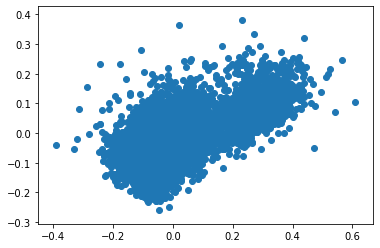

In [88]:
plt.scatter(abundances_calibrated[3],abundances_calibrated_est[3])
#plt.ylim(-1,1)
#plt.xlim(-0.1,0.1)


## Non-linear better

### Setup

In [37]:
feedforward = Feedforward([n_z,512,256,128,1],activation=nn.SELU()).to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(feedforward.parameters(),lr=0.0001)


In [38]:
truth_tensor = torch.tensor(abundances_calibrated[0]).to(device)
#truth_tensor = (truth_tensor-min(truth_tensor))/(max(truth_tensor)-min(truth_tensor))

In [50]:
for i in range(10):
    for j,(x,u,idx) in enumerate(loader):
        optimizer.zero_grad()
        x_pred,z = autoencoder(x[:,1000:3000].to(device))
        pred = feedforward(z.detach())
        true = truth_tensor[idx]
        
        err = loss(pred,true.unsqueeze(1))    
        err.backward()
        optimizer.step()
        if j%100==0:
            print(f"epoch:{i},err:{err}")


epoch:0,err:0.04886316508054733
epoch:1,err:0.004038079641759396
epoch:2,err:0.002585254143923521
epoch:3,err:0.0016085354145616293
epoch:4,err:0.0020687291398644447
epoch:5,err:0.002569836098700762
epoch:6,err:0.0034540658816695213
epoch:7,err:0.004151961300522089
epoch:8,err:0.0017810655990615487
epoch:9,err:0.0015756104839965701


In [41]:
nonlinear_array = np.array([get_v(i,dataset).detach().cpu().numpy() for i in range(n_datapoints)]).squeeze()


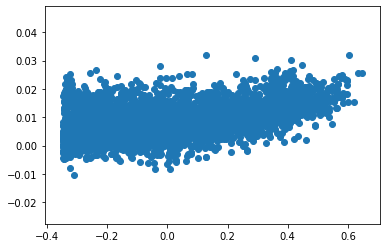

In [42]:
plt.scatter(abundances_calibrated[0],nonlinear_array)

In [43]:
nonlinear_array.shape

(5000,)

In [89]:
abundances_calibrated[0][:3000]

array([ 0.03601545,  0.13167286, -0.1265741 , ..., -0.05736411,
        0.07408386,  0.04865289], dtype=float32)